In [1]:
# Initial Imports:

import pandas as pd
from pathlib import Path
import pandas_datareader.data as reader
import datetime as dt
import statsmodels.api as sm
import getFamaFrenchFactors as gff

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# For visualizations:
import seaborn as sns

# PART I: DATA CAPTURE AND ORGANIZATION

## NOTE: Momentum factor is optional in this code

In [2]:
end = dt.date(2021, 12, 31)
start = dt.date(2020, 1, 1)
ticker = ["BTC-USD"]

In [3]:
# Get BTC closing prices

btc_dreturns = reader.get_data_yahoo(ticker, start, end)["Close"]
display(btc_dreturns.head())
btc_dreturns.tail()

Symbols,BTC-USD
Date,
2020-01-01,7200.174316
2020-01-02,6985.470215
2020-01-03,7344.884277
2020-01-04,7410.656738
2020-01-05,7411.317383


Symbols,BTC-USD
Date,
2021-12-28,47588.855469
2021-12-29,46444.710938
2021-12-30,47178.125000
2021-12-31,46306.445312
2022-01-01,47686.812500


In [4]:
# Get daily returns of BTC

btc_dreturns = btc_dreturns.pct_change().dropna() #convert to daily returns and drop NaN values
display(btc_dreturns.head())
btc_dreturns.tail()

Symbols,BTC-USD
Date,
2020-01-02,-0.029819
2020-01-03,0.051452
2020-01-04,0.008955
2020-01-05,0.000089
2020-01-06,0.048291


Symbols,BTC-USD
Date,
2021-12-28,-0.060259
2021-12-29,-0.024042
2021-12-30,0.015791
2021-12-31,-0.018476
2022-01-01,0.029809


In [5]:
# Get daily factor data  

ff3_daily = reader.DataReader("F-F_Research_Data_Factors_daily", "famafrench", start, end)[0]  
ff3_daily.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2020-01-02,0.86,-0.90,-0.31,0.006
2020-01-03,-0.67,0.38,0.00,0.006
2020-01-06,0.36,-0.06,-0.55,0.006
2020-01-07,-0.19,-0.01,-0.24,0.006
2020-01-08,0.47,-0.06,-0.64,0.006


In [6]:
# Divide select columns by 100 (because inputted Mkt-RF, SMB, and HML columns are in percentages while RF column is not).

ff3_daily[["Mkt-RF", "SMB", "HML"]] = ff3_daily[["Mkt-RF", "SMB", "HML"]]/100 
ff3_daily.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2020-01-02,0.0086,-0.0090,-0.0031,0.006
2020-01-03,-0.0067,0.0038,0.0000,0.006
2020-01-06,0.0036,-0.0006,-0.0055,0.006
2020-01-07,-0.0019,-0.0001,-0.0024,0.006
2020-01-08,0.0047,-0.0006,-0.0064,0.006


In [7]:
# Read in Momentum factor data from CSV included in Resources folder of this repo.
# Note: as per this notebook, using Momentum as a factor can be turned on and off with hashes in applicable cells.
# This notebook is set up to use it or not use it, depending on user preference.
# Across a number of time periods, we have not found it to be a significant factor with BTC.

momentum_factor = pd.read_csv(
    Path("./Resources/F-F_Momentum_Factor_daily.csv"),
    header=None
)

momentum_factor

,0,1
0,19261103,0.56
1,19261104,-0.50
2,19261105,1.17
3,19261106,-0.03
4,19261108,-0.01
...,...,...
25106,20220329,-1.98
25107,20220330,1.03
25108,20220331,0.40
25109,NaN,NaN


In [8]:
# Asssign column names

momentum_factor.columns = ["Date", "Mom"]
momentum_factor.columns

Index(['Date', 'Mom'], dtype='object')

In [9]:
# Choose select dates 

momentum_factor = momentum_factor.loc[
    (momentum_factor["Date"] >= "20200101")
    &(momentum_factor["Date"] <= "20211231")
]

In [10]:
display(momentum_factor.head())
momentum_factor.tail()

,Date,Mom
24542,20200102,0.82
24543,20200103,0.03
24544,20200106,-0.69
24545,20200107,0.01
24546,20200108,0.92


,Date,Mom
25042,20211227,1.93
25043,20211228,-0.53
25044,20211229,0.41
25045,20211230,-1.05
25046,20211231,0.43


In [11]:
# Set index

momentum_factor.set_index("Date")

,Mom
Date,
20200102,0.82
20200103,0.03
20200106,-0.69
20200107,0.01
20200108,0.92
...,...
20211227,1.93
20211228,-0.53
20211229,0.41


In [12]:
# Drop NaNs

momentum_factor = momentum_factor.dropna()
momentum_factor.shape

(505, 2)

In [13]:
# Divide by 100 (because inputted Mom column is in percentages).

momentum_factor["Mom"] = momentum_factor["Mom"]/100  
momentum_factor.head()

,Date,Mom
24542,20200102,0.0082
24543,20200103,0.0003
24544,20200106,-0.0069
24545,20200107,0.0001
24546,20200108,0.0092


In [14]:
# Set index to the index of ff3_daily dataframe.

momentum_factor.index = ff3_daily.index

In [15]:
# Drop extra column

momentum_factor.drop(columns="Date", inplace=True)
momentum_factor

,Mom
Date,
2020-01-02,0.0082
2020-01-03,0.0003
2020-01-06,-0.0069
2020-01-07,0.0001
2020-01-08,0.0092
...,...
2021-12-27,0.0193
2021-12-28,-0.0053
2021-12-29,0.0041


In [16]:
# Merging FF3 daily facotr data with BTC daily return data into one dataframe

regress_data = ff3_daily.merge(btc_dreturns, on="Date")  
display(regress_data.head())
regress_data.tail()

,Mkt-RF,SMB,HML,RF,BTC-USD
Date,,,,,
2020-01-02,0.0086,-0.0090,-0.0031,0.006,-0.029819
2020-01-03,-0.0067,0.0038,0.0000,0.006,0.051452
2020-01-06,0.0036,-0.0006,-0.0055,0.006,0.048291
2020-01-07,-0.0019,-0.0001,-0.0024,0.006,0.050774
2020-01-08,0.0047,-0.0006,-0.0064,0.006,-0.010269


,Mkt-RF,SMB,HML,RF,BTC-USD
Date,,,,,
2021-12-27,0.0122,-0.0010,0.0029,0.0,-0.003328
2021-12-28,-0.0027,-0.0059,0.0081,0.0,-0.060259
2021-12-29,0.0006,-0.0006,0.0016,0.0,-0.024042
2021-12-30,-0.0015,0.0010,-0.0041,0.0,0.015791
2021-12-31,-0.0031,0.0005,0.0052,0.0,-0.018476


In [17]:
# Merging combined FF3 daily factor and BTC daily returns data with Momentum daily factor data

#regress_data = data.merge(momentum_factor, on="Date")  
#regress_data = regress_data[["Mkt-RF", "SMB", "HML", "Mom", "RF", "BTC-USD"]] #ordering columns
#display(regress_data.head())
#regress_data.tail()

In [18]:
# Subtracting risk-free return rate from BTC's daily returns and creating a new column to store the result

regress_data["BTC-RF"] = regress_data["BTC-USD"] - regress_data["RF"]
regress_data.head()

,Mkt-RF,SMB,HML,RF,BTC-USD,BTC-RF
Date,,,,,,
2020-01-02,0.0086,-0.0090,-0.0031,0.006,-0.029819,-0.035819
2020-01-03,-0.0067,0.0038,0.0000,0.006,0.051452,0.045452
2020-01-06,0.0036,-0.0006,-0.0055,0.006,0.048291,0.042291
2020-01-07,-0.0019,-0.0001,-0.0024,0.006,0.050774,0.044774
2020-01-08,0.0047,-0.0006,-0.0064,0.006,-0.010269,-0.016269


<AxesSubplot:xlabel='Mkt-RF', ylabel='BTC-RF'>

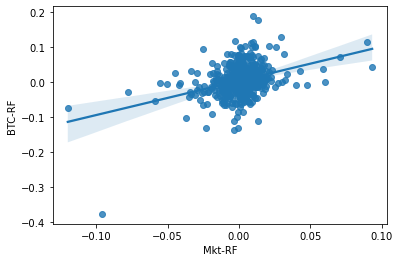

In [19]:
# Checking relationships between two variables graphically using seaborn regplot. Scatter plot shows excess returns on the 
# market versus excess returns on BTC.

sns.regplot(x="Mkt-RF", y="BTC-RF", data=regress_data) 

In [20]:
X = regress_data[["Mkt-RF", "SMB", "HML"]]  #the independent variables     
# X = regress_data[["Mkt-RF", "SMB", "HML", "Mom"]] #the independent variables four 4 factors
y = regress_data["BTC-RF"]  #the dependent variable

X1 = sm.add_constant(X) #defining the constant
model = sm.OLS(y, X1)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BTC-RF   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     32.19
Date:                Tue, 10 May 2022   Prob (F-statistic):           4.82e-19
Time:                        17:51:38   Log-Likelihood:                 903.14
No. Observations:                 505   AIC:                            -1798.
Df Residuals:                     501   BIC:                            -1781.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.471      0.142      -0.001       0.006
Mkt-RF         0.9685      0.112      8.666      0.000       0.749       1.188
SMB            0.7593      0.214      3.542      0.000       0.338       1.181
HML           -0.3253      0.133     -2.454      0.014      -0.586      -0.065
==============================================================================
Omnibus:                       87.502   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              665.314
Skew:                          -0.496   Prob(JB):                    3.38e-145
Kurtosis:                       8.535   Cond. No.                         120.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
#Note: The Prob (F-statistic) depicts probability of the null hypothesis being true, and can be thought of as the p-value for the 
#regression as a whole. Our F-statistic of effectively 0 implies that overall the regressions were significant.

#Last thing are the coefficients and the p-values for the X variables. The coefficients tell you the size of the effect that 
#the variable is having on the dependent variable when all other independent variables are held constant. Because the p-values
#are < .05, the coefficients are deemed significant.

In [22]:
# Saving the coefficients, which tell us how much exposure BTC has to the market, size, value, and momentum. 
# Note on Fama French Factors: There is some systematic risk due to size, value (book equity to market equity), and momementum of 
# stocks. Stock risks are multidimensional! 

intercept, beta_m, beta_s, beta_v = results.params  
#intercept, beta_m, beta_s, beta_v, beta_mom = results.params   #for 4 factors
print(beta_m, beta_s, beta_v)
# print(beta_m, beta_s, beta_v, beta_mom)   #for 4 factors 

0.9684990224815865 0.75934946292776 -0.3253205908518386


In [23]:
# Getting average risk free rate

risk_free = regress_data["RF"].mean()
risk_free

0.0007366336633663371

In [24]:
# Calculating expected excess return of the market (the market risk premium). Note, all is based on daily returns! So as calculated here, 
# the average daily return of the S&P500 (in excess of risk-free rate) during this period is .0975%.
# Calculating expected excess return due to size (the size risk premium).
# Calculating expected excess return due to value (the value risk premium).
# Calculating expected excess return due to momentum (the momentum risk premium).

market_premium = regress_data["Mkt-RF"].mean()
size_premium = regress_data["SMB"].mean()
value_premium = regress_data["HML"].mean()
#momentum_premium = regress_data["Mom"].mean()  #use for 4 factors

print(market_premium, size_premium, value_premium)  #monthly premiums, shows how market, size, value, momentum yield premiums
#print(market_premium, size_premium, value_premium, momentum_premium) #use for 4 factors

0.0009754455445544558 0.0001893069306930687 -0.000233465346534654


In [25]:
#Compute expected return of BTC 

btc_exp_return = intercept + risk_free + (beta_m * market_premium) + (beta_s * size_premium) + (beta_v * value_premium) 
#btc_exp_return = risk_free + (beta_m * market_premium) + (beta_s * size_premium) + (beta_v * value_premium) + (beta_mom * momentum_premium) #use for 4 factors

btc_exp_yr_return = btc_exp_return * 252

print(f"Using the Fama French Four Factor model, the expected daily return of Bitcoin is: %{btc_exp_return*100}.")
print(f"Using the Fama French Four Factor model, the expected annual return of Bitcoin is: %{btc_exp_yr_return*100}.")

Using the Fama French Four Factor model, the expected daily return of Bitcoin is: %0.45667218347489635.
Using the Fama French Four Factor model, the expected annual return of Bitcoin is: %115.08139023567388.


# PART III: TRAINING AND TESTING THE DATA

In [26]:
# Split data into training data (80%) and test data (20%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [27]:
# Instantiate

model = LinearRegression()

In [28]:
# Fit

model.fit(X_train, y_train)

LinearRegression()

In [29]:
# Predict

y_pred = model.predict(X_test)

In [30]:
# Model evaluation

score = r2_score(y_test, y_pred)
percent_score = round((score * 100), 2)

print(f"Your model will correctly predict the price of Bitcoin {percent_score}% of the time.")
print(f"Or in other words, {percent_score}% of BTC's excess return on the market is explained by these factors.")

Your model will correctly predict the price of Bitcoin 12.22% of the time.
Or in other words, 12.22% of BTC's excess return on the market is explained by these factors.
